In [437]:
import matplotlib
from matplotlib import pylab, patches
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import scipy.stats
import sys
import yaml

sys.path.insert(1, '/home/ksf293/external')
import illustris_python as il

from IPython.display import display, Markdown
%load_ext autoreload
%autoreload 2

sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [483]:
plot_dir = '../plots/plots_2022-09-16'

In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [6]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [9]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Gather properties

In [176]:
sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Viz

81.58317
0.709870053063035
0.2901299469369651
0.01513035764156988


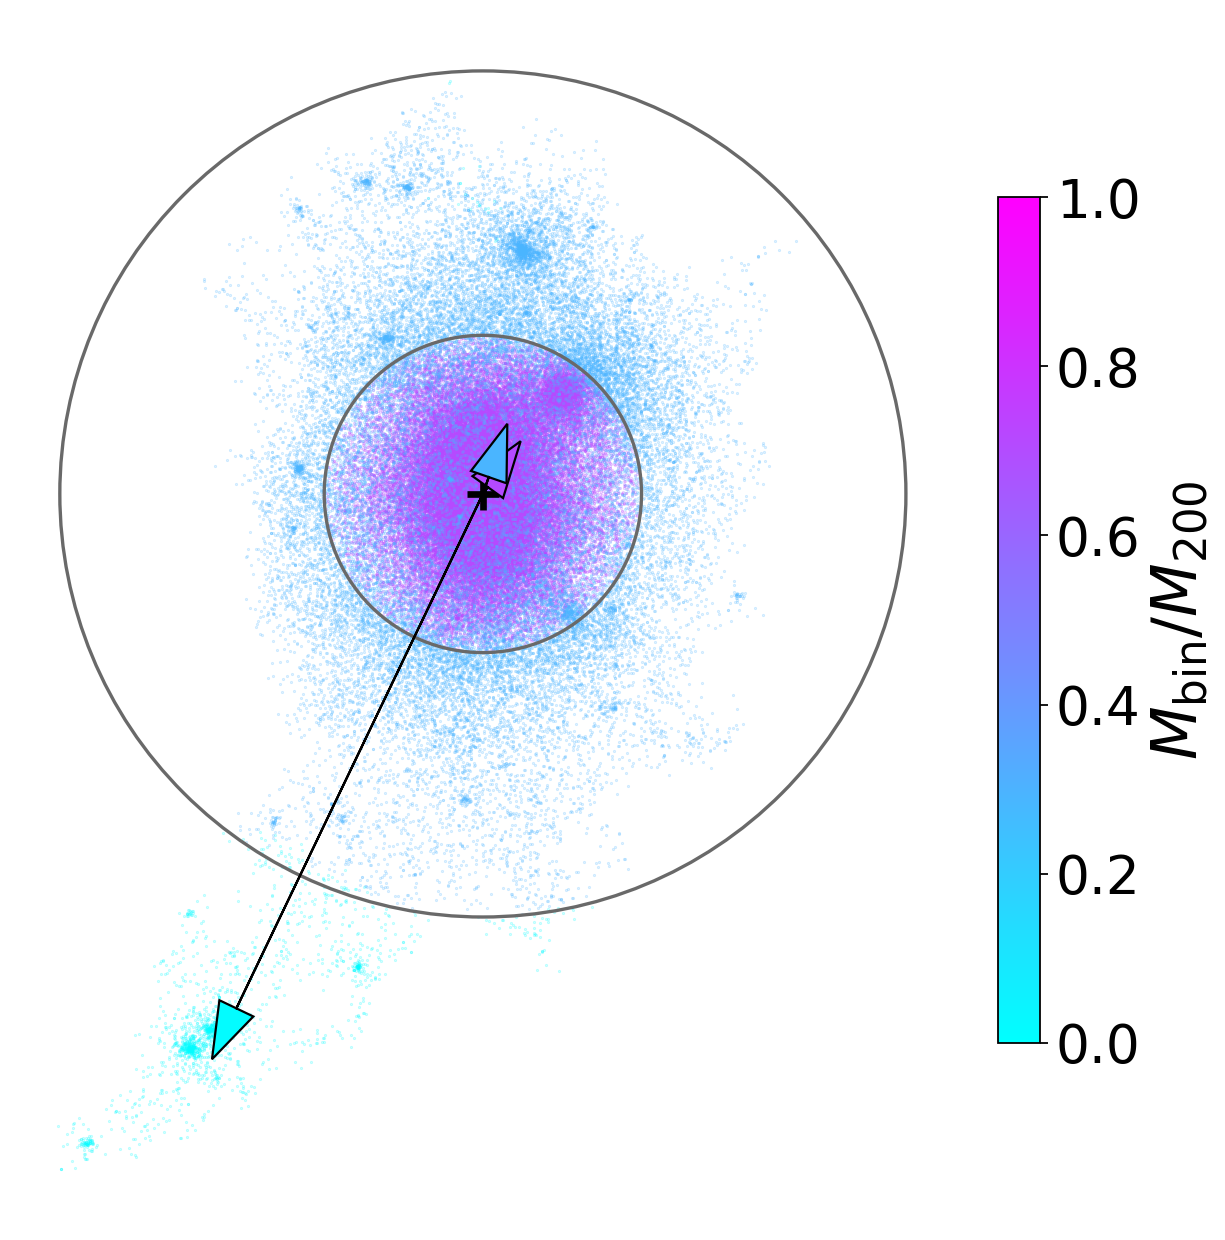

In [25]:
bin_edges_frac = [0, 3/8, 1, 10]
idx = 2197 
halo = sim_reader.dark_halo_arr[idx]
print(halo.catalog_properties['m200m'])
geos = scalar_featurizer.geo_feature_arr[idx]
plotter.plot_halo_dark_geometric(sim_reader.base_path_dark, sim_reader.snap_num, sim_reader.m_dmpart_dark, halo, bin_edges_frac)

# Check correlations

(array([8.000e+00, 5.100e+01, 3.380e+02, 4.168e+03, 3.784e+03, 2.834e+03,
        2.084e+03, 1.608e+03, 1.187e+03, 9.030e+02, 6.770e+02, 5.100e+02,
        3.970e+02, 2.700e+02, 2.070e+02, 1.650e+02, 1.300e+02, 1.100e+02,
        5.700e+01, 5.800e+01, 4.200e+01, 2.000e+01, 1.600e+01, 1.300e+01,
        1.800e+01, 5.000e+00, 0.000e+00, 4.000e+00, 3.000e+00, 3.000e+00]),
 array([10.398056 , 10.536892 , 10.675728 , 10.814564 , 10.953401 ,
        11.0922365, 11.231072 , 11.369908 , 11.508744 , 11.64758  ,
        11.786416 , 11.925252 , 12.064089 , 12.202925 , 12.341761 ,
        12.480597 , 12.619432 , 12.758268 , 12.897104 , 13.035941 ,
        13.174777 , 13.313613 , 13.452449 , 13.591285 , 13.730121 ,
        13.868957 , 14.007792 , 14.146629 , 14.285465 , 14.424301 ,
        14.563137 ], dtype=float32),
 <BarContainer object of 30 artists>)

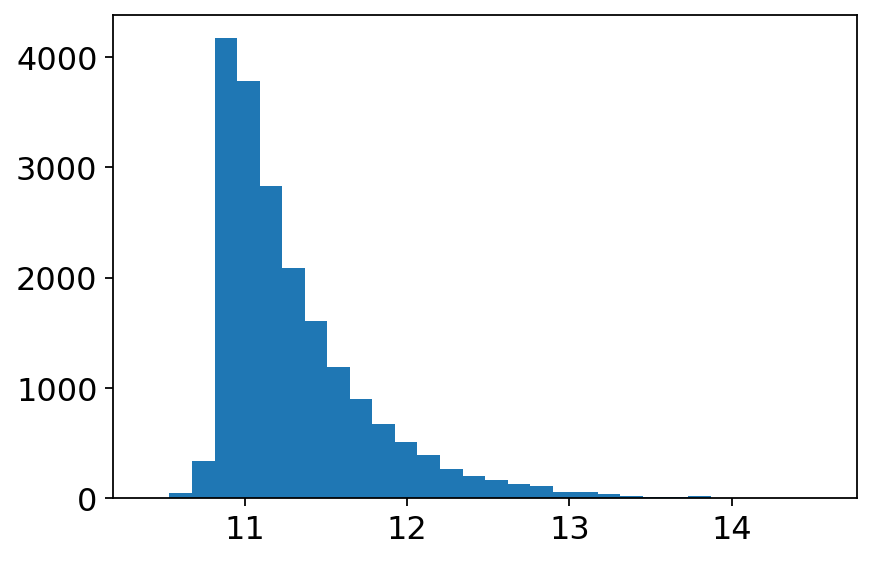

In [110]:
plt.hist(log_m_200m+log_mass_shift, bins=30)

In [41]:
scalar_featurizer.scalar_features.shape

(19670, 567)

In [42]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)

In [43]:
scalar_featurizer.scalar_features.shape

(19670, 567)

In [44]:
corrs = []
for i in range(scalar_featurizer.scalar_features.shape[1]):
    feats = scalar_featurizer.scalar_features[:,i]
    #res = scipy.stats.pearsonr(feats, y)
    res = scipy.stats.spearmanr(feats, y)
    corrs.append(res[0])
corrs = np.array(corrs)

567


Text(0.5, 0, 'correlation coefficient')

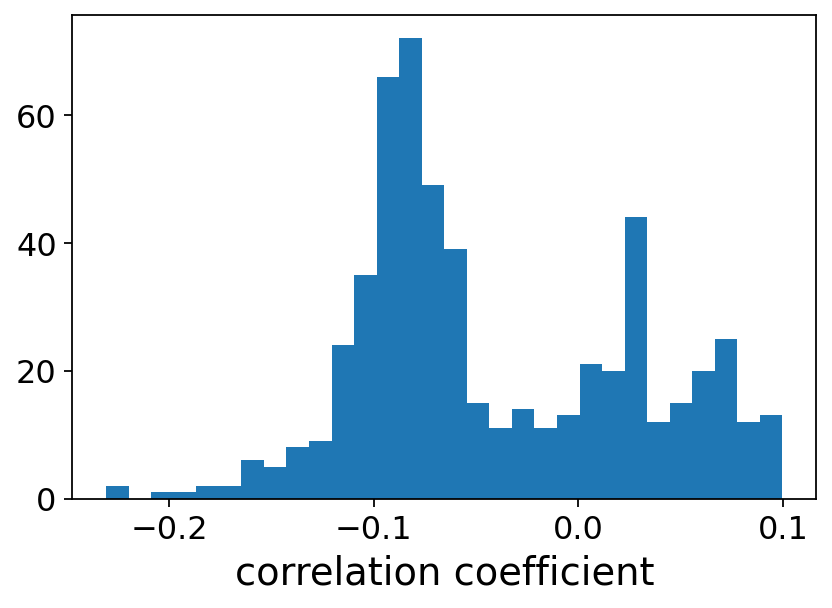

In [45]:
print(len(corrs))
plt.hist(corrs, bins=30)
plt.xlabel("correlation coefficient")

In [46]:
corrs_abs = np.abs(corrs)
i_feats_sorted = np.argsort(corrs_abs)[::-1]

In [47]:
n_print = 20
for ii in range(n_print):
    i_feat = i_feats_sorted[ii]
    print(i_feat, scalar_name(scalar_featurizer.scalar_feature_arr[0][i_feat], scalar_featurizer.geo_feature_arr))

31 $m_0 \, m_1$
302 $[C^{vv}_0]_{jk} \, [C^{xx}_1]_{jk}$
44 $\lambda_2\left(C^{vv}_0\right) \, m_1$
40 $\lambda_1\left(C^{vv}_0\right) \, m_1$
41 $\lambda_3\left(C^{vv}_0\right) \, m_1$
300 $\lambda_1\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$
320 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$
82 $[C^{vv}_0]_{jk} \, [C^{vv}_1]_{jk}$
318 $\lambda_2\left(C^{vv}_0\right) \, \lambda_2\left(C^{xx}_1\right)$
321 $\lambda_3\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$
42 $m_0 \, \lambda_3\left(C^{vv}_1\right)$
305 $\lambda_2\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$
84 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$
301 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$
299 $\lambda_1\left(C^{vv}_0\right) \, \lambda_3\left(C^{xx}_1\right)$
43 $m_0 \, \lambda_2\left(C^{vv}_1\right)$
81 $\lambda_2\left(C^{vv}_0\right) \, \lambda_3\left(C^{vv}_1\right)$
78 $\lambda_3\left(C^{vv}_0\right) \, \lambda_2\lef

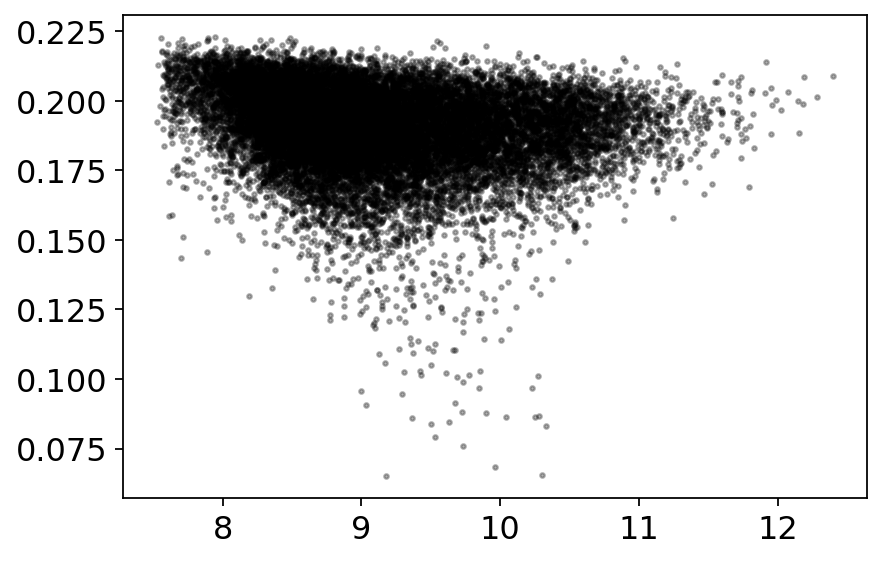

In [48]:
i_feat = 31
plt.scatter(y+log_mass_shift, scalar_featurizer.scalar_features[:,i_feat], color='k', s=4, alpha=0.3)

(0.0, 0.15)

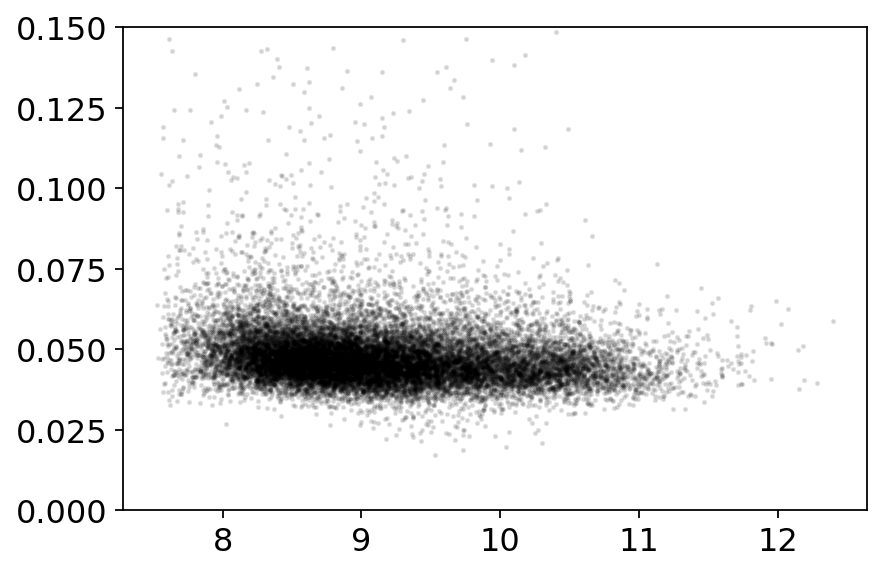

In [49]:
i_feat = 302
plt.scatter(y+log_mass_shift, scalar_featurizer.scalar_features[:,i_feat], color='k', s=2, alpha=0.1)
plt.ylim(0,0.15)

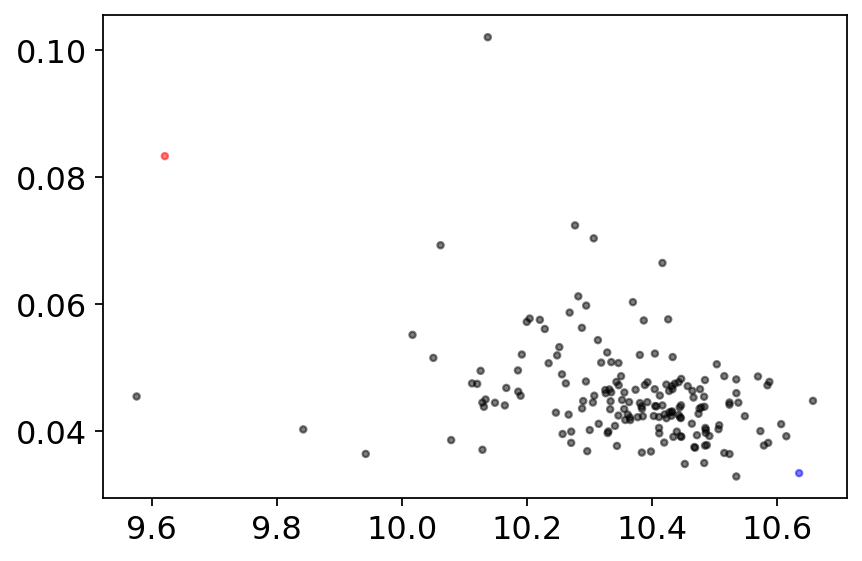

In [62]:
mbin = [12, 12.05]
idx_mbin = (log_m_200m + log_mass_shift >= mbin[0]) & (log_m_200m + log_mass_shift < mbin[1])
np.sum(idx_mbin)

i_feat = 302
i1 = np.argsort(scalar_featurizer.scalar_features[idx_mbin,i_feat])[-2]
i2 = np.argsort(scalar_featurizer.scalar_features[idx_mbin,i_feat])[1]
colors = ['k']*np.sum(idx_mbin)
colors[i1] = 'red'
colors[i2] = 'blue'
plt.scatter(y[idx_mbin]+log_mass_shift, scalar_featurizer.scalar_features[idx_mbin,i_feat], c=colors, s=8, alpha=0.5)
#plt.ylim(0,0.15)

9.427176117897034


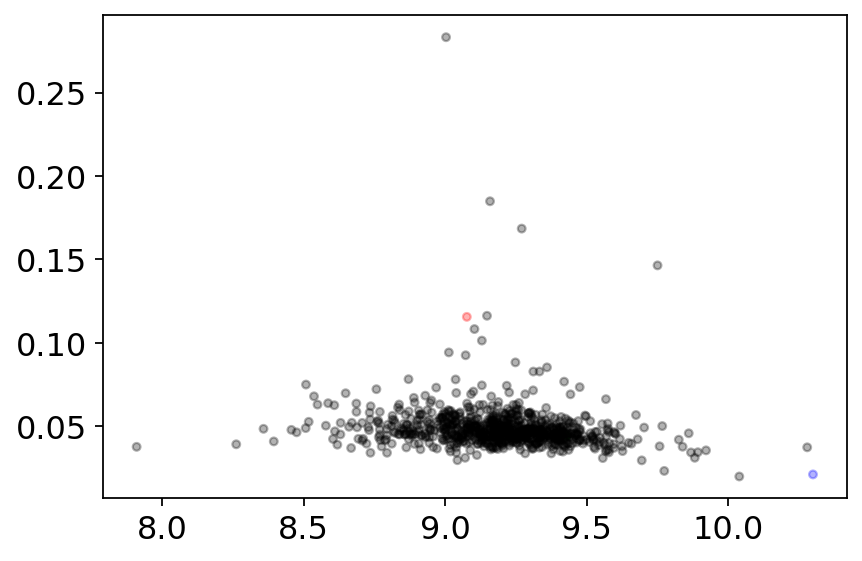

In [146]:
mbin = [11.25, 11.3]
idx_mbin = (log_m_200m + log_mass_shift >= mbin[0]) & (log_m_200m + log_mass_shift < mbin[1])
np.sum(idx_mbin)

i_feat = 302
# i1 = np.argsort(scalar_featurizer.scalar_features[idx_mbin,i_feat])[-2]
# i2 = np.argsort(scalar_featurizer.scalar_features[idx_mbin,i_feat])[1]
feats_argsorted = np.argsort(scalar_featurizer.scalar_features[idx_mbin,i_feat])
i1 = feats_argsorted[-6]
i2 = feats_argsorted[len(feats_argsorted)//3]
print(y[idx_mbin][i2]+log_mass_shift)
i3 = feats_argsorted[1]
colors = ['k']*np.sum(idx_mbin)
colors[i1] = 'red'
colors[i2] = 'green'
colors[i3] = 'blue'
plt.scatter(y[idx_mbin]+log_mass_shift, scalar_featurizer.scalar_features[idx_mbin,i_feat], c=colors, s=12, alpha=0.3)
#plt.ylim(0,0.15)

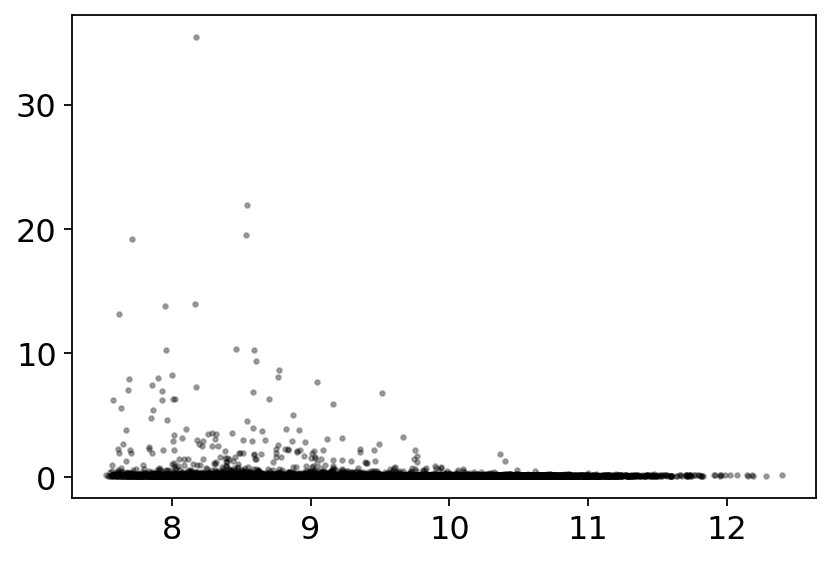

In [63]:
i_feat = 40
plt.scatter(y+log_mass_shift, scalar_featurizer.scalar_features[:,i_feat], color='k', s=4, alpha=0.3)
#plt.yscale("log")

(0.0, 0.2)

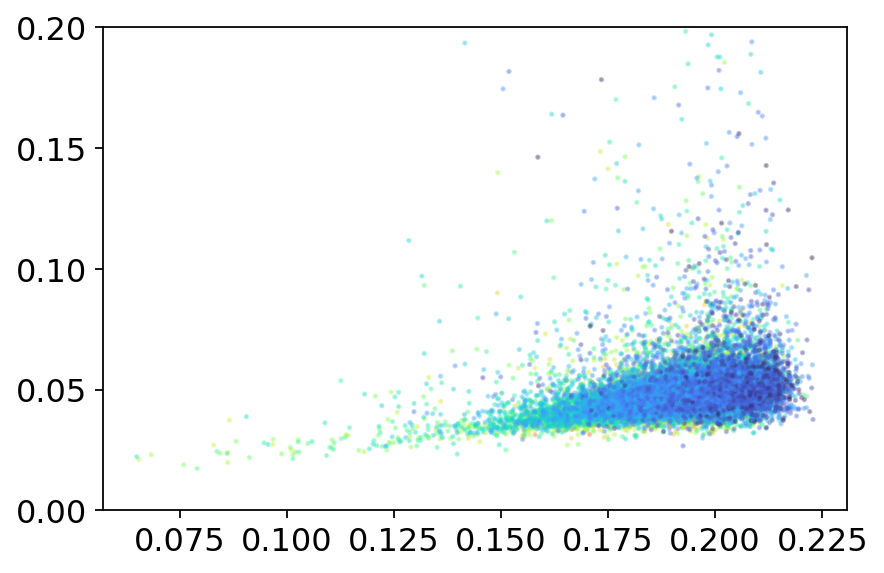

In [76]:
i_feats = 31, 302
plt.scatter(scalar_featurizer.scalar_features[:,i_feats[0]], scalar_featurizer.scalar_features[:,i_feats[1]], 
            c=y+log_mass_shift, s=2, alpha=0.3, cmap='turbo')
#plt.yscale("log")
plt.ylim(0, 0.2)

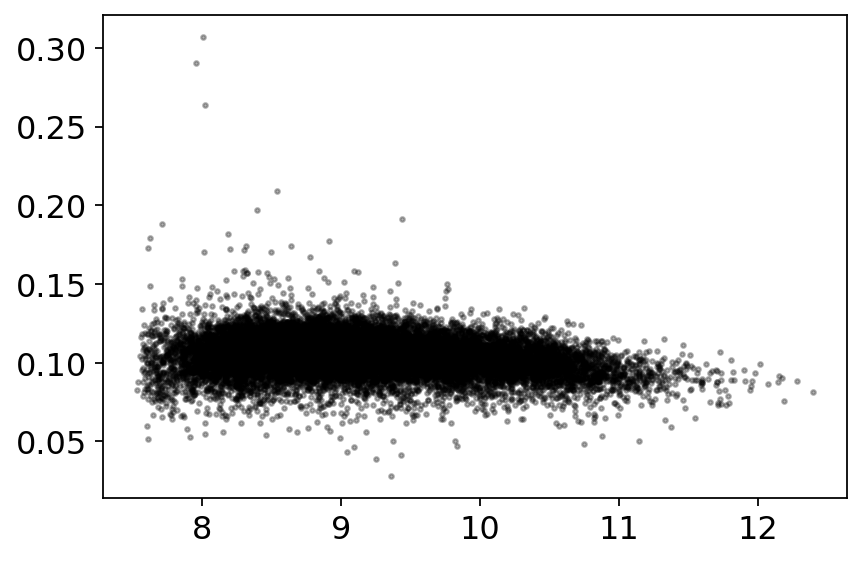

In [56]:
i_feat = 41
plt.scatter(y+log_mass_shift, scalar_featurizer.scalar_features[:,i_feat], color='k', s=4, alpha=0.3)

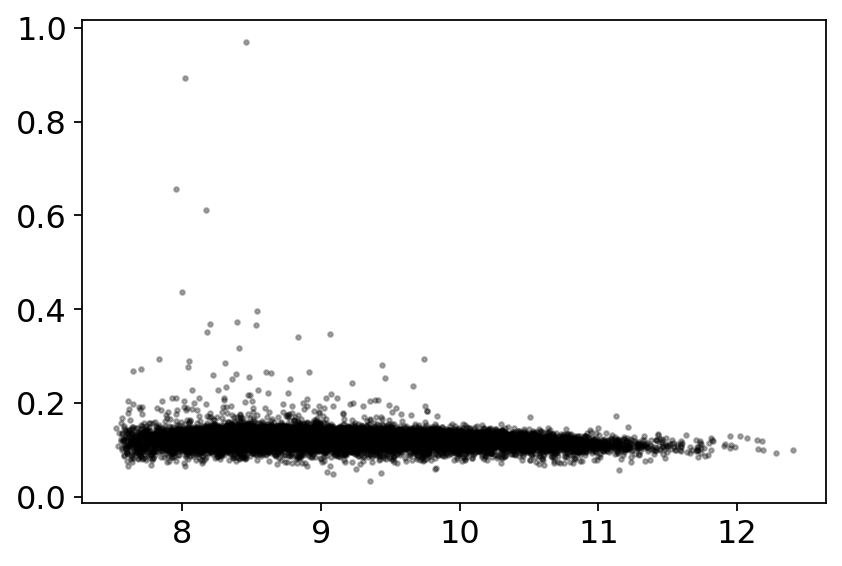

In [49]:
i_feat = 44
plt.scatter(y+log_mass_shift, scalar_featurizer.scalar_features[:,i_feat], color='k', s=4, alpha=0.3)

In [14]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)

In [28]:
mbin = [12, 12.5]
idx_mbin = (log_m_200m + log_mass_shift >= mbin[0]) & (log_m_200m + log_mass_shift < mbin[1])
np.sum(idx_mbin)

1133

In [29]:
corrs_mbin = []
for i in range(scalar_featurizer.scalar_features.shape[1]):
    feats = scalar_featurizer.scalar_features[idx_mbin,i]
    #res = scipy.stats.pearsonr(feats, y)
    res = scipy.stats.spearmanr(feats, y[idx_mbin])
    corrs_mbin.append(res[0])
corrs_mbin = np.array(corrs_mbin)

In [30]:
corrs_mbin_abs = np.abs(corrs_mbin)
i_feats_sorted_mbin = np.argsort(corrs_mbin_abs)[::-1]

In [31]:
n_print = 10
for ii in range(n_print):
    i_feat = i_feats_sorted_mbin[ii]
    print(i_feat, scalar_name(scalar_featurizer.scalar_feature_arr[0][i_feat], scalar_featurizer.geo_feature_arr))

301 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{xx}_1\right)$
518 $\lambda_3\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_0\right)$
532 $\lambda_1\left(C^{xx}_0\right) \, \lambda_1\left(C^{xx}_1\right)$
367 $[\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk} \, [\frac{1}{2} (C^{xv}_1 + C^{vx}_1)]_{jk}$
40 $\lambda_1\left(C^{vv}_0\right) \, m_1$
76 $\lambda_1\left(C^{vv}_0\right) \, \lambda_1\left(C^{vv}_1\right)$
21 $\lambda_2\left(C^{xx}_0\right)$
522 $\lambda_2\left(C^{xx}_0\right) \, \lambda_2\left(C^{xx}_0\right)$
22 $\lambda_3\left(C^{xx}_0\right)$
517 $\lambda_3\left(C^{xx}_0\right) \, \lambda_3\left(C^{xx}_0\right)$


(0.0, 0.15)

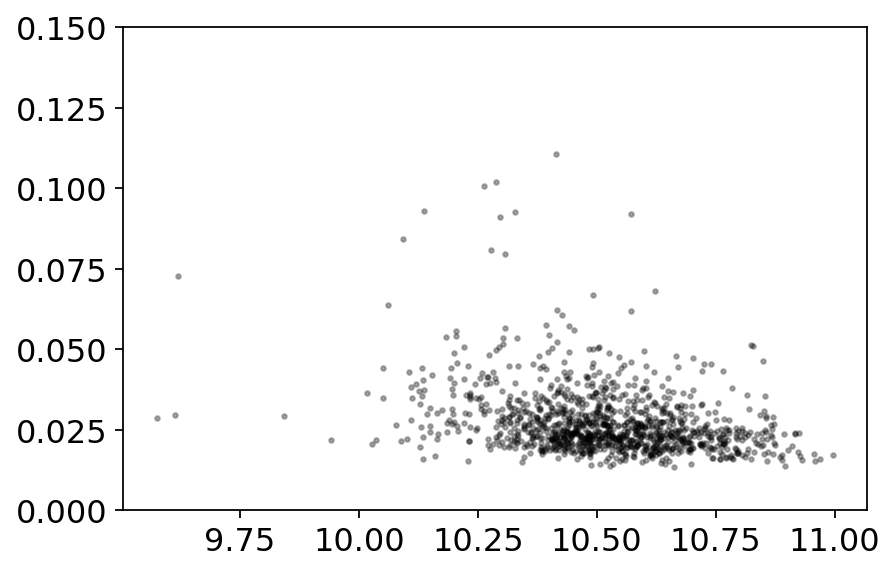

In [34]:
i_feat = 301
plt.scatter(y[idx_mbin]+log_mass_shift, scalar_featurizer.scalar_features[idx_mbin,i_feat], 
            color='k', s=4, alpha=0.3)
plt.ylim(0,0.15)

(0.0, 0.4)

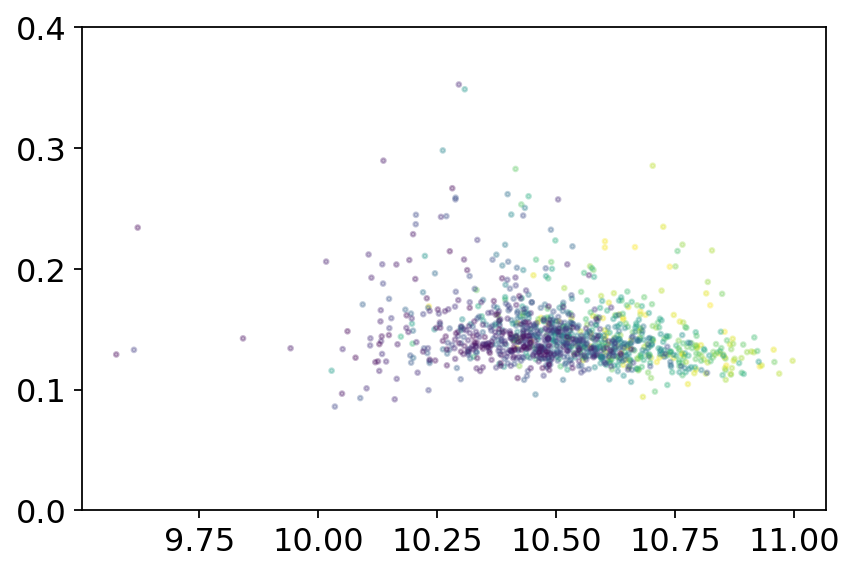

In [40]:
i_feat = 40
plt.scatter(y[idx_mbin]+log_mass_shift, scalar_featurizer.scalar_features[idx_mbin,i_feat], 
            c=log_m_200m[idx_mbin], s=4, alpha=0.3)
plt.ylim(0,0.4)

In [137]:
def plot_halo_dark(base_path_dark, snap_num, halo, width=None):
        # Dark sim
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    
    s_dm = 0.03
    alpha = 0.05
    # want absolute positions, not shifted, so get directly from illustris
    x_halo_dark_dm, _ = halo.load_positions_and_velocities(center='x_minPE')
    #halo_dark_dm = il.snapshot.loadHalo(base_path_dark,snap_num,halo.idx_halo_dark,'dm')
    #x_halo_dark_dm = halo_dark_dm['Coordinates']
    #x_halo_dark_dm = halo.shift_x(x_halo_dark_dm, center='x_minPE')
    ax.scatter(x_halo_dark_dm[:,0], x_halo_dark_dm[:,1], 
               s=s_dm, alpha=alpha, marker='.', color='darkblue', label='Dark halo DM')  
    ax.set_aspect('equal')
    plt.axis('off')
    
    if width is not None:
        com = np.mean(x_subhalo_hydro_stars, axis=0)
        print(com.shape)
        ax.set_xlim(com[0]-width/2, com[0]+width/2)
        ax.set_ylim(com[1]-width/2, com[1]+width/2)
        
    xlim = ax.get_xlim()
    return xlim[1]-xlim[0]

In [135]:
def plot_galaxy(base_path_hydro, snap_num, halo, width=None):
        # Dark sim
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    
    s_hydro = 0.5
    alpha = 0.5

    # Hydro sim
#     halo_hydro_dm = il.snapshot.loadHalo(base_path_hydro,snap_num,halo.idx_halo_hydro,'dm')
#     x_halo_hydro_dm = halo_hydro_dm['Coordinates']
#     #x_halo_hydro_dm = halo.shift_x(x_halo_hydro_dm, center='x_minPE')
#     ax.scatter(x_halo_hydro_dm[:,0], x_halo_hydro_dm[:,1], 
#                s=s_dm, alpha=alpha, marker='.', color='rebeccapurple', label='Hydro halo DM')

    subhalo_hydro_stars = il.snapshot.loadSubhalo(base_path_hydro,snap_num,halo.idx_subhalo_hydro,'stars')
    if subhalo_hydro_stars['count'] > 0:
        x_subhalo_hydro_stars = subhalo_hydro_stars['Coordinates']
        ax.scatter(x_subhalo_hydro_stars[:,0], x_subhalo_hydro_stars[:,1],
                   s=s_hydro, alpha=alpha, marker='.', color='orange')

    if width is not None:
        com = np.mean(x_subhalo_hydro_stars, axis=0)
        print(com.shape)
        ax.set_xlim(com[0]-width/2, com[0]+width/2)
        ax.set_ylim(com[1]-width/2, com[1]+width/2)
        
    print(ax.get_xlim())
    ax.set_aspect('equal')
    plt.axis('off')
    xlim = ax.get_xlim()
    return xlim[1]-xlim[0]

1606.4951618972111

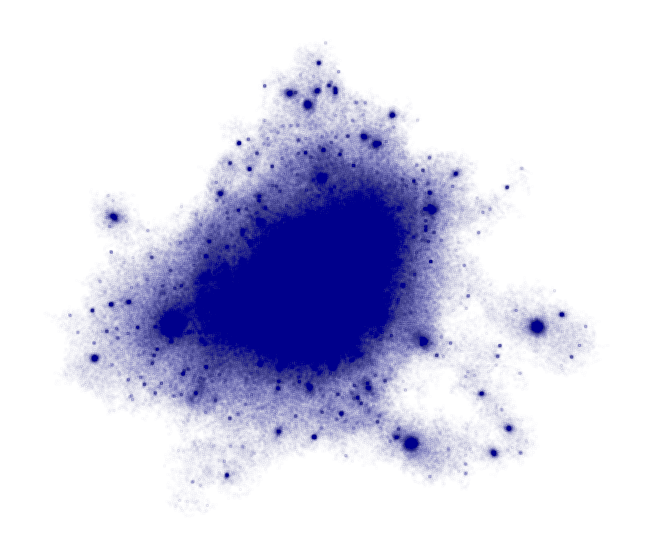

In [138]:
halo = sim_reader.dark_halo_arr[i1]
plot_halo_dark(sim_reader.base_path_dark, sim_reader.snap_num, halo)

(28442.0596027081, 29749.495380804594)


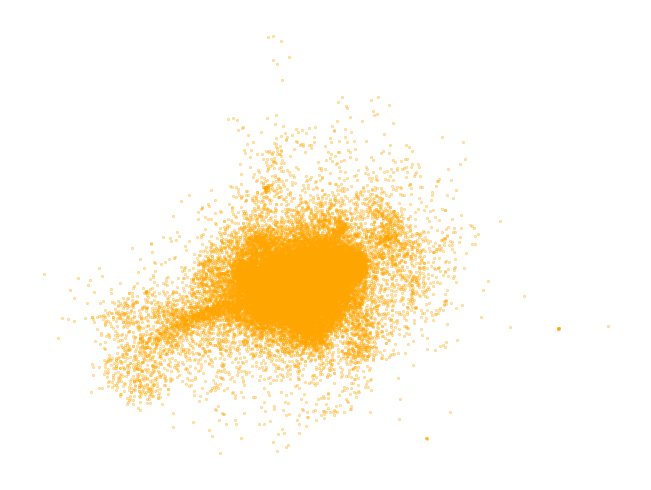

In [131]:
halo = sim_reader.dark_halo_arr[i1]
width = plot_galaxy(sim_reader.base_path_hydro, sim_reader.snap_num, halo)

984.5512445849258

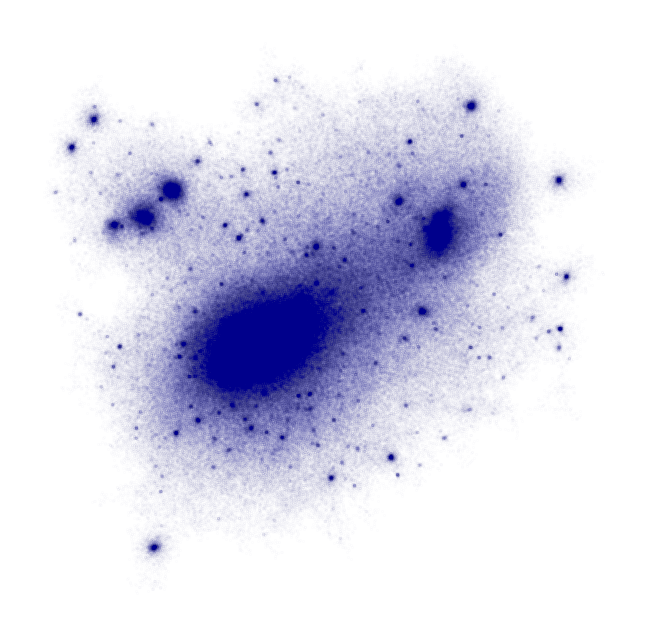

In [147]:
halo = sim_reader.dark_halo_arr[i2]
plot_halo_dark(sim_reader.base_path_dark, sim_reader.snap_num, halo)

807.6675611001483

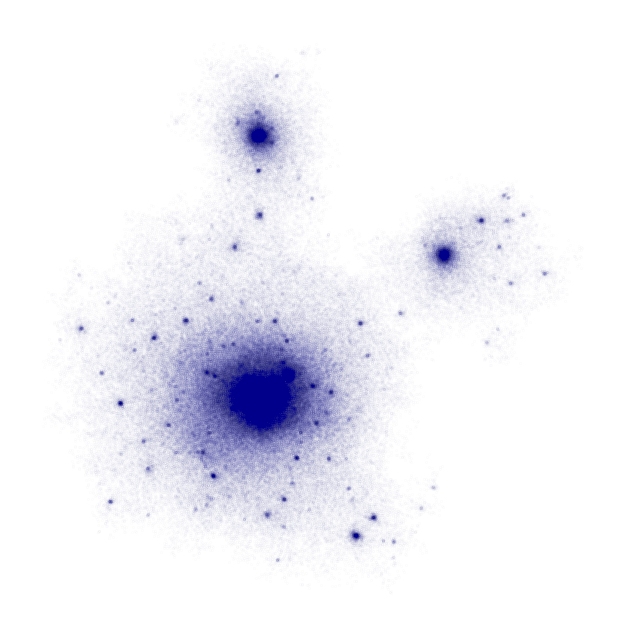

In [139]:
halo = sim_reader.dark_halo_arr[i2]
plot_halo_dark(sim_reader.base_path_dark, sim_reader.snap_num, halo)

(3,)
(43086.33969986946, 44393.77547796595)


1307.4357780964929

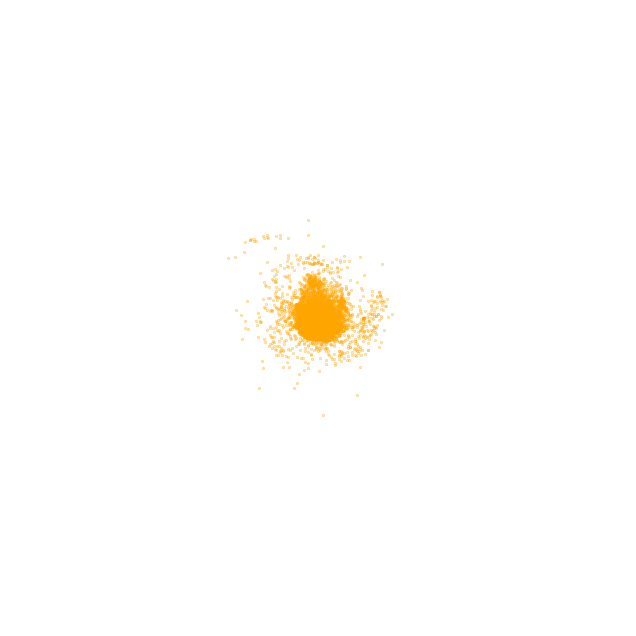

In [136]:
halo = sim_reader.dark_halo_arr[i2]
plot_galaxy(sim_reader.base_path_hydro, sim_reader.snap_num, halo, width=width)

In [484]:
def halo_dark(ax, base_path_dark, snap_num, halo, width=None, color='darkblue'):
    
    s_dm = 0.1
    alpha = 0.3
    
    x_minPE = halo.catalog_properties['x_minPE']

    x_halo_dark_dm, _ = halo.load_positions_and_velocities(shift=False)
    ax.scatter(x_halo_dark_dm[:,0], x_halo_dark_dm[:,1], 
               s=s_dm, alpha=alpha, marker='o', color=color)  
    ax.set_aspect('equal')
    ax.axis('off')

    if width is not None:
        ax.set_xlim(x_minPE[0]-width/2, x_minPE[0]+width/2)
        ax.set_ylim(x_minPE[1]-width/2, x_minPE[1]+width/2)


In [435]:
def galaxy(ax, base_path_hydro, snap_num, halo, width=None, color='orange'):
    
    s_hydro = 0.5
    alpha = 0.5
    
    x_minPE_hydro = halo.catalog_properties['x_minPE_hydro']
    
    subhalo_hydro_stars = il.snapshot.loadSubhalo(base_path_hydro,snap_num,halo.idx_subhalo_hydro,'stars')
    if subhalo_hydro_stars['count'] > 0:
        x_subhalo_hydro_stars = subhalo_hydro_stars['Coordinates']
        ax.scatter(x_subhalo_hydro_stars[:,0], x_subhalo_hydro_stars[:,1],
                   s=s_hydro, alpha=alpha, marker='o', color=color)

    ax.set_aspect('equal')
    ax.axis('off')
    
    if width is not None:
        ax.set_xlim(x_minPE_hydro[0]-width/2, x_minPE_hydro[0]+width/2)
        ax.set_ylim(x_minPE_hydro[1]-width/2, x_minPE_hydro[1]+width/2)

In [486]:
cmap_blues = utils.shiftedColorMap(matplotlib.cm.get_cmap('Blues'), 
                                   start=0.4, midpoint=0.65, stop=0.9, name='shiftedcmap')

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


In [451]:
cmap_oranges = utils.shiftedColorMap(matplotlib.cm.get_cmap('YlOrBr_r'), 
                                   start=0.4, midpoint=0.6, stop=0.8, name='shiftedcmap')

In [501]:
def plot_halos(halos, properties_halo, properties_gal, base_path_dark, base_path_hydro, snap_num,
               property_halo_name='', property_gal_name=''):
    
    n_halos = len(halos)
    fig, axarr = plt.subplots(2, n_halos, figsize=(16,6))
    plt.subplots_adjust(hspace=-0.2, wspace=-0.7)
    
    plt.text(0, 0.4, 'Dark matter halos\n(DM-only sim),\n'+r'$M_\mathrm{halo}=11.25$', transform=axarr[0,0].transAxes, 
             fontsize=14, horizontalalignment='right')
    plt.text(0, 0.4, 'Central galaxies\n(Matched hydro sim)', transform=axarr[1,0].transAxes, 
             fontsize=14, horizontalalignment='right')    
    width_dark = 500
    width_hydro = 100

    
    # halo color things
    locs_norm1 = matplotlib.colors.Normalize(vmin=np.min(properties_halo), vmax=np.max(properties_halo))
    colors_halo = [cmap_blues(locs_norm1(p)) for p in properties_halo]
    sm1 = plt.cm.ScalarMappable(cmap=cmap_blues, norm=locs_norm1)
    cb_ax1 = fig.add_axes([0.8, 0.53, 0.008, 0.26])
    cbar1 = plt.colorbar(sm1, cax=cb_ax1)
    cbar1.set_label('invariant\nshape feature\n'+rf'{property_halo_name}', rotation=0, labelpad=80)
    
    # galaxy color things
    locs_norm2 = matplotlib.colors.Normalize(vmin=np.min(properties_gal), vmax=np.max(properties_gal))
    colors_gal = [cmap_oranges(locs_norm2(p)) for p in properties_gal]
    sm2 = plt.cm.ScalarMappable(cmap=cmap_oranges, norm=locs_norm2)
    cb_ax2 = fig.add_axes([0.8, 0.2, 0.008, 0.26])
    cbar2 = plt.colorbar(sm2, cax=cb_ax2)
    cbar2.set_label(rf'{property_gal_name}', rotation=0, labelpad=100)
    
    for i in range(n_halos):

        halo_dark(axarr[0,i], base_path_dark, snap_num, halos[i], width=width_dark, color=colors_halo[i])
        galaxy(axarr[1,i], base_path_hydro, snap_num, halos[i], width=width_hydro, color=colors_gal[i])

        # https://stackoverflow.com/questions/60807792/arrows-between-matplotlib-subplots
        arrow = patches.ConnectionPatch(
            [0.5, 0],
            [0.5, 1],
            coordsA=axarr[0,i].transAxes,
            coordsB=axarr[1,i].transAxes,
            color="black",
            arrowstyle="<|-",  # "normal" arrow
            mutation_scale=10,  # controls arrow head size
            linewidth=1,
            )
        fig.patches.append(arrow)

In [318]:
i_halos = [i3, i2, i1]
halos = [sim_reader.dark_halo_arr[idx_mbin][i] for i in i_halos]
print([halo.catalog_properties['m200m']*mass_multiplier for halo in halos])
print([log_m_200m[idx_mbin][i] for halo in halos])

[182060565948.48633, 196765804290.77148, 181622581481.9336]
[1.2687473, 1.2687473, 1.2687473]


In [377]:
properties_halo = [scalar_featurizer.scalar_features[idx_mbin][i][i_feat] for i in i_halos]
property_halo_name = scalar_name(scalar_featurizer.scalar_feature_arr[0,i_feat], scalar_featurizer.geo_feature_arr)
print(property_halo_name)

$[C^{vv}_0]_{jk} \, [C^{xx}_1]_{jk}$


In [427]:
properties_gal = [y[idx_mbin][i]+log_mass_shift for i in i_halos]
property_gal_name = utils.label_dict[y_label_name]
print(properties_gal)
print(property_gal_name)

[10.299490988254547, 9.427176117897034, 9.076551139354706]
log($m_\mathrm{stellar} \: [h^{-1} \, M_\odot]$)


In [416]:
matplotlib.rcParams["figure.dpi"] = 500

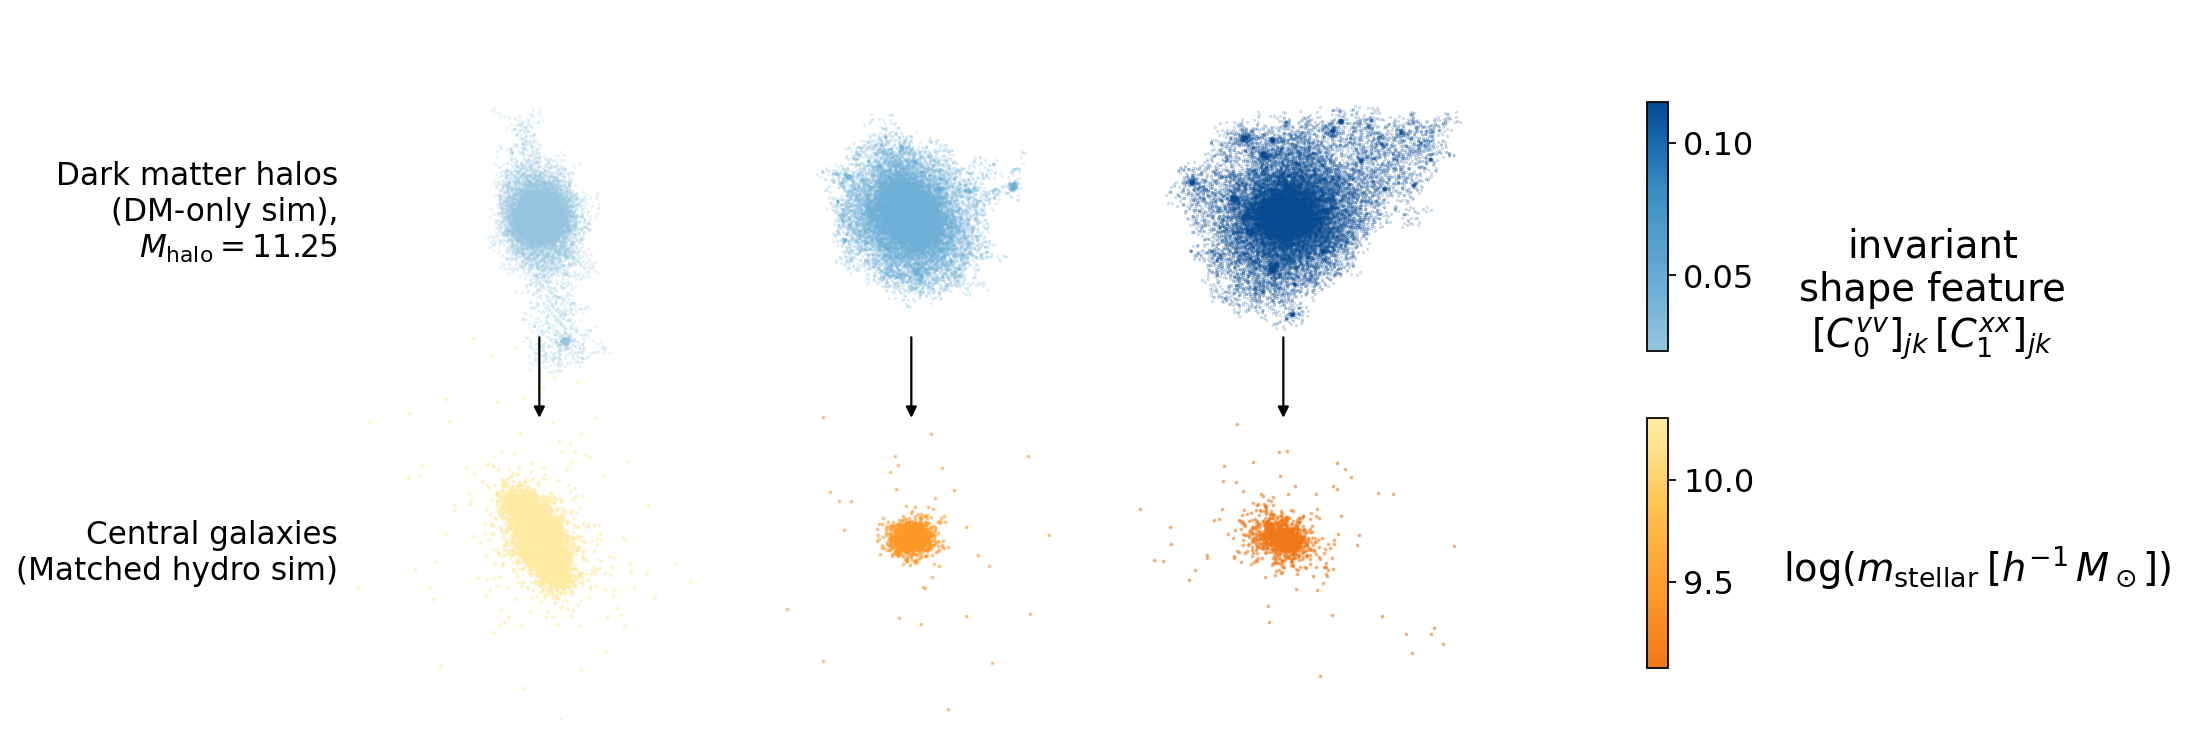

In [502]:
plot_halos(halos, properties_halo, properties_gal, 
           sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
           property_halo_name=property_halo_name, property_gal_name=property_gal_name)

plt.savefig(f'{plot_dir}/halo_gal_match_viz.pdf')
plt.savefig(f'{plot_dir}/halo_gal_match_viz.png', dpi=1000)